# News Category Prediction Project Documentation


## 1. Project Overview
This project aims to build a machine learning pipeline to classify news articles into one of five categories: **Business, Entertainment, Politics, Sport, or Tech**. The project explores both methods:
1.  **Traditional Machine Learning** using TF-IDF features.
2.  **Deep Learning** using Long Short-Term Memory (LSTM) networks.

The workflow includes data exploration, text cleaning, feature engineering, model training, evaluation, and saving the final models for future use.


## 2. Dependencies
The project relies on the following key Python libraries:
-   **Data Manipulation**: `pandas`, `numpy`
-   **Visualization**: `seaborn`, `matplotlib.pyplot`, `wordcloud`
-   **Machine Learning**: `sklearn` (Scikit-learn) - for model selection, vectorization, and metrics.
-   **Deep Learning**: `tensorflow.keras` - for building the LSTM model.
-   **Serialization**: `joblib`, `pickle` - for saving models and artifacts.



In [31]:
# ======= Standard Libraries =======
import os
import re
import string
import pickle

# ======= Data Handling =======
import numpy as np
import pandas as pd

# ======= Visualization =======
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ======= NLP =======
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ======= Scikit-Learn =======
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ======= ML Models =======
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# ======= DL / Keras =======
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ======= Model Persistence =======
import joblib

## 3. Data Loading and Exploration (EDA)
The dataset is loaded from a CSV file `bbc_news_text_complexity_summarization.csv`.

### Key Steps:
1.  **Loading Data**: Data is read into a Pandas DataFrame.
2.  **Initial Inspection**: `df.head()` and `df.info()` are used to understand the structure and types of the data.
3.  **Data Cleaning**: Duplicate records are identified and removed using `df.drop_duplicates(inplace=True)` to ensure data quality.
4.  **Target Distribution**: A count plot (`sns.histplot`) visualizes the balance of classes (labels) to check for dataset imbalance.
5.  **Text Analysis**: The lengths of articles (word counts) are analyzed and visualized for each category using histograms, helping to understand the text distribution.



In [2]:
df = pd.read_csv("bbc_news_text_complexity_summarization.csv")

In [3]:
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   text                          2127 non-null   object 
 1   labels                        2127 non-null   object 
 2   no_sentences                  2127 non-null   int64  
 3   Flesch Reading Ease Score     2127 non-null   float64
 4   Dale-Chall Readability Score  2127 non-null   float64
 5   text_rank_summary             2127 non-null   object 
 6   lsa_summary                   2127 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 116.4+ KB


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
X = df['text']
y = df['labels']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

## EDA

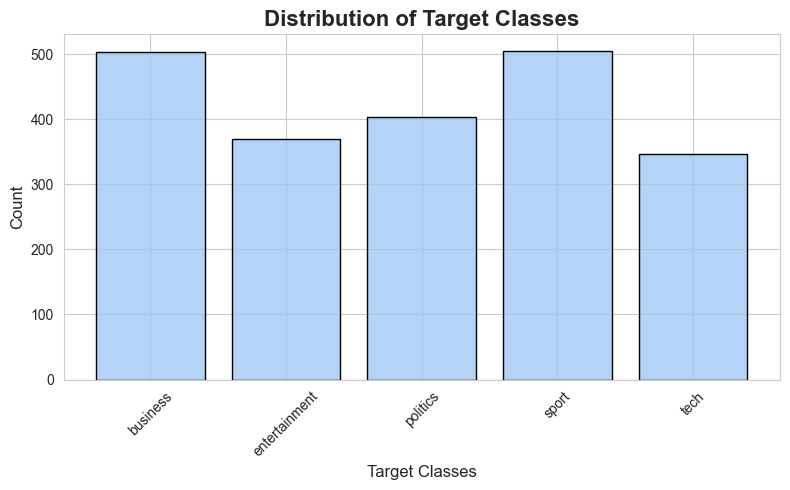

In [ ]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
sns.set_palette("pastel")

sns.histplot(
    data=df, 
    x='labels', 
    shrink=0.8,
    edgecolor='black', 
    alpha=0.8
)

plt.title('Distribution of Target Classes', fontsize=16, fontweight='bold')
plt.xlabel('Target Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

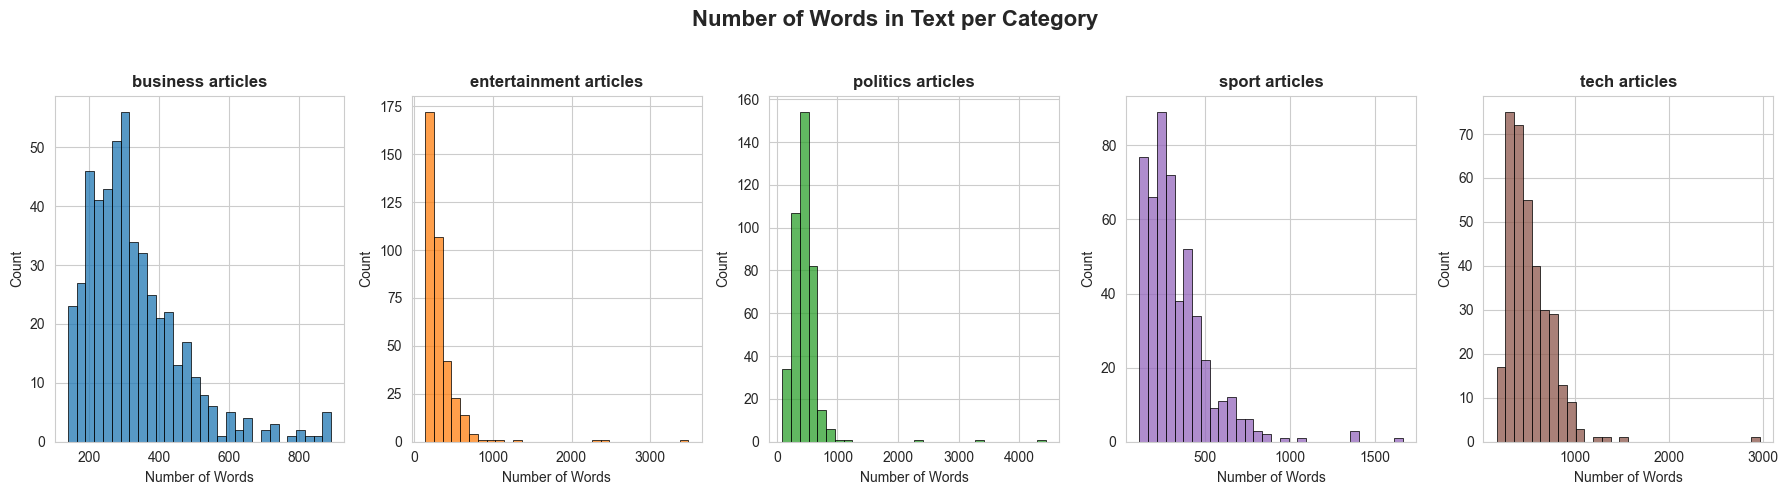

In [ ]:
labels = df['labels'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

fig, axes = plt.subplots(1, len(labels), figsize=(18,5))
sns.set_style("whitegrid")

for ax, label, color in zip(axes, labels, colors):
    word_len = df[df['labels'] == label]['text'].str.split().str.len()
    
    sns.histplot(word_len, bins=30, kde=False, color=color, edgecolor='black', ax=ax)
    
    ax.set_title(f'{label} articles', fontsize=12, fontweight='bold')
    ax.set_xlabel('Number of Words', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)

plt.suptitle("Number of Words in Text per Category", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [44]:
df['word_count'] = df['text'].str.split().str.len()
mean_words = df.groupby('labels')['word_count'].mean().reset_index()

mean_words.rename(columns={'word_count':'Mean Words'}, inplace=True)
print(mean_words)

          labels  Mean Words
0       business  328.675944
1  entertainment  332.707317
2       politics  456.220844
3          sport  330.623762
4           tech  513.236311


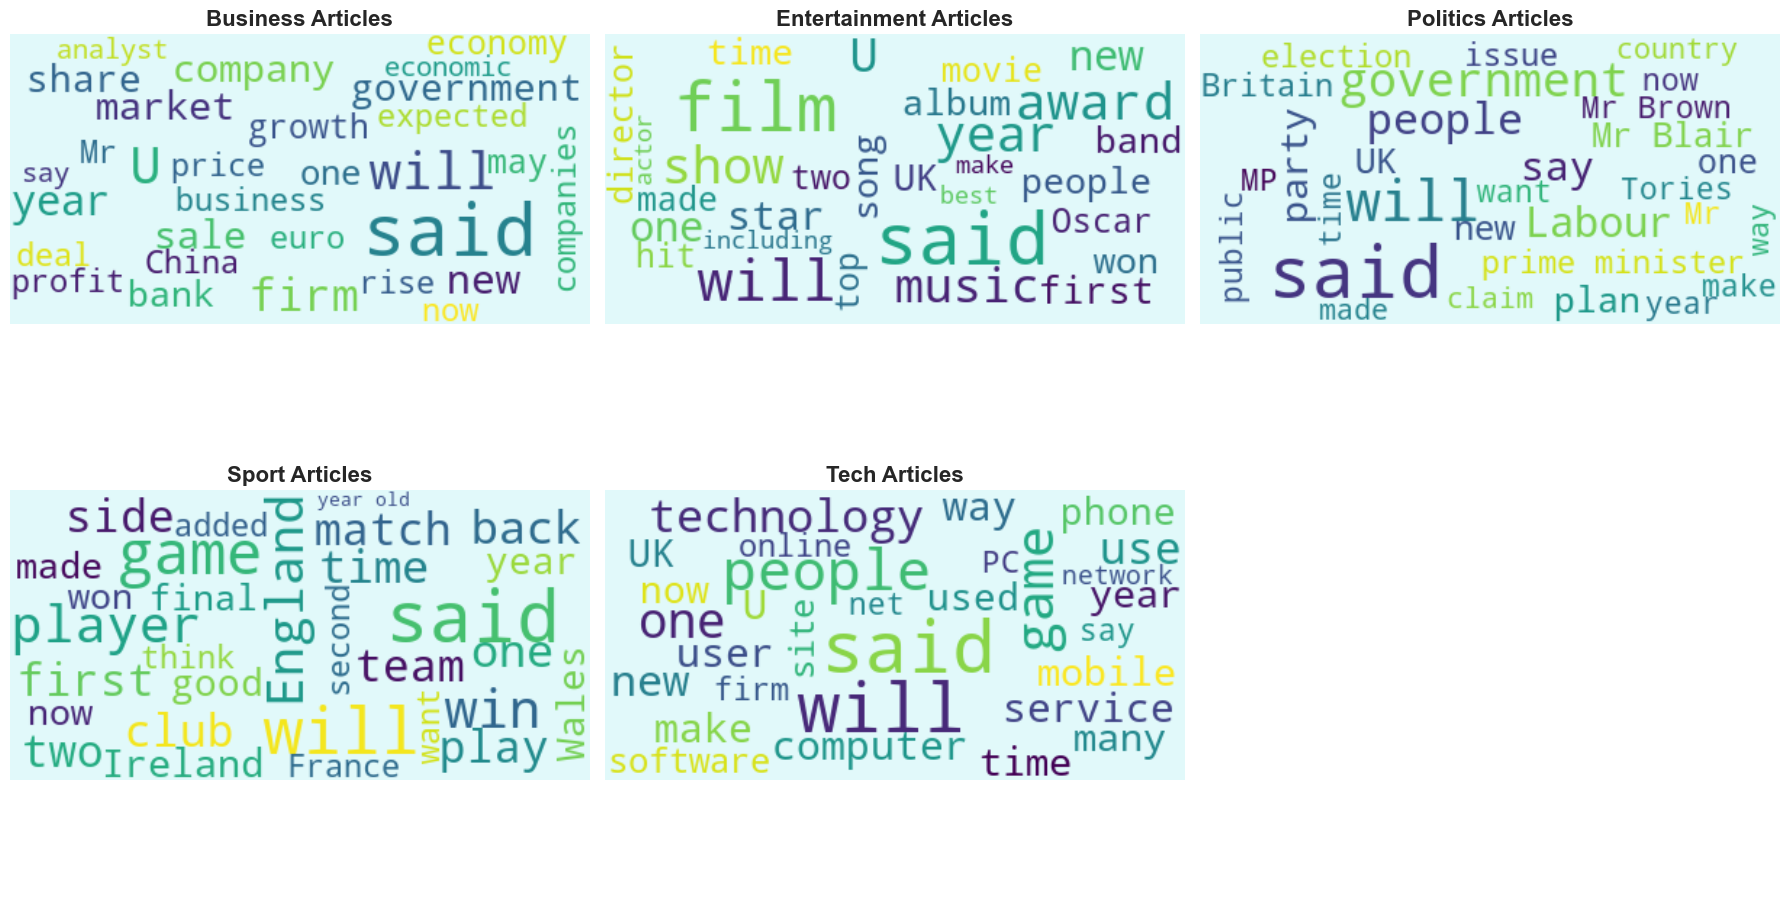

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for ax, label, color in zip(axes, labels, colors):
    text = ' '.join(df[df['labels'] == label]['text'])
    
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=30,
        background_color='#e1f9fa',
        colormap=None
    ).generate(text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"{label.capitalize()} Articles", fontsize=16, fontweight='bold')

for i in range(len(labels), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Text Preprocessing

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZeyadaNet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZeyadaNet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ZeyadaNet\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def text_manipulation_advanced(data, remove_numbers=True, remove_stopwords=True, do_lemmatize=True):
    data_out = data.copy()
    
    punct = string.punctuation + "\n\r"
    data_out = (
        data_out
        .str.replace(f"[{punct}]", "", regex=True)
        .str.lower()
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True) 
    )
    
    def clean_text(text):
        words = text.split()
        if remove_stopwords:
            words = [w for w in words if w not in stop_words]
        if do_lemmatize:
            words = [lemmatizer.lemmatize(w) for w in words]
        return ' '.join(words)
    
    data_out = data_out.apply(clean_text)
    
    return data_out

In [14]:
X_train = text_manipulation_advanced(X_train)
X_test  = text_manipulation_advanced(X_test)

## 5. Approach 1: Traditional Machine Learning
This approach uses statistical methods for prediction.

### Feature Engineering
-   **TF-IDF (Term Frequency-Inverse Document Frequency)**: Converts text documents into a matrix of token counts, weighted by their importance. This transforms the text into numerical features suitable for ML algorithms.

### Models Trained
The following classifiers are trained and evaluated:
1.  **Logistic Regression**: A baseline linear model for classification.
2.  **Random Forest**: An ensemble method using decision trees.
3.  **XGBoost**: An optimized gradient boosting framework.
4.  **SVC (Support Vector Classifier)**: Finds the hyperplane that best divides the classes.

### Evaluation
The code iterates through these models, trains them on the TF-IDF features, and prints classification reports (Precision, Recall, F1-Score) for comparison. Based on the logs, **XGBoost** is identified as a strong performer.



In [15]:
vectorizer = TfidfVectorizer(max_features=5000)  
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect  = vectorizer.transform(X_test)

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

In [17]:

def get_test_scores_multiclass(name, y_pred, y_true):
    scores = {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    return scores


In [18]:
num_classes = len(y.unique())
models = [
    ('XGB', XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')),
    ('SVC', SVC(probability=True, random_state=42))
]

In [19]:
trained_models = {}
results = []

for name, model in models:
    
    # Train
    model.fit(X_train_vect, y_train)
    
    # Save trained model
    trained_models[name] = model
    
    # Predict on train (for overfitting check)
    y_train_pred = model.predict(X_train_vect)
    
    # Metrics
    results.append(
        get_test_scores_multiclass(name, y_train_pred, y_train)
    )

results_df = pd.DataFrame(results)
results_df

d:\ERU\AitronixEnv\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1
0,XGB,1.000000,1.000000,1.000000,1.000000
1,RandomForest,1.000000,1.000000,1.000000,1.000000
2,LogisticRegression,0.995611,0.995622,0.995611,0.995612
3,SVC,1.000000,1.000000,1.000000,1.000000


In [20]:
from sklearn.metrics import classification_report
for name, model in models:
    y_test_pred = model.predict(X_test_vect)
    print(f"=== Classification Report: {name} ===")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

=== Classification Report: XGB ===
               precision    recall  f1-score   support

     business       0.96      0.94      0.95       134
entertainment       0.97      0.93      0.95        98
     politics       0.95      0.97      0.96        86
        sport       0.97      0.99      0.98       127
         tech       0.93      0.97      0.95        87

     accuracy                           0.96       532
    macro avg       0.96      0.96      0.96       532
 weighted avg       0.96      0.96      0.96       532

=== Classification Report: RandomForest ===
               precision    recall  f1-score   support

     business       0.97      0.99      0.98       134
entertainment       1.00      0.92      0.96        98
     politics       0.95      0.98      0.97        86
        sport       0.96      1.00      0.98       127
         tech       0.99      0.98      0.98        87

     accuracy                           0.97       532
    macro avg       0.98      0.97  

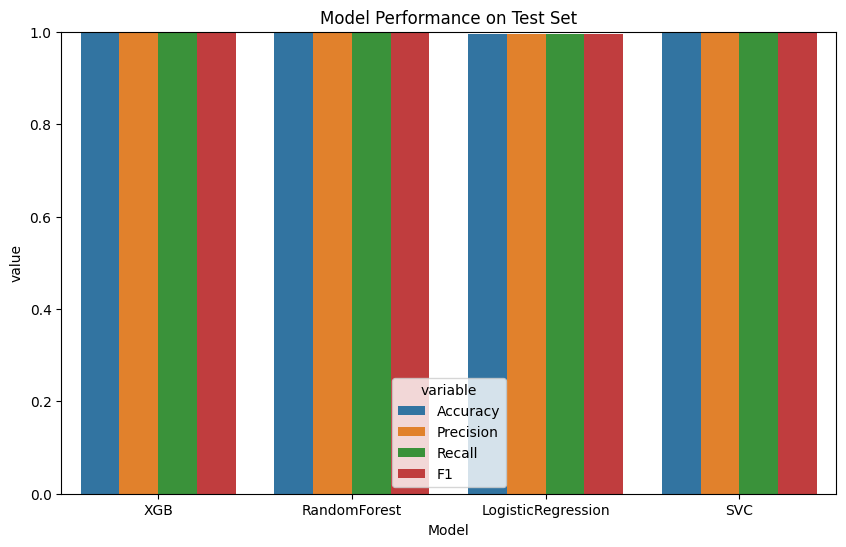

In [21]:


metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

plt.figure(figsize=(10,6))
sns.barplot(data=results_df.melt(id_vars='Model', value_vars=metrics), 
            x='Model', y='value', hue='variable')
plt.ylim(0,1)
plt.title('Model Performance on Test Set')
plt.show()

## 7. New Data Predictions
The notebook demonstrates how to predict categories for unseen articles.

### Workflow:
1.  **Input**: A list of new, raw news articles string.
2.  **Preprocessing**: The `clean_text_dl` function is applied.
3.  **Vectorization**: The *already fitted* TF-IDF vectorizer transforms the new text.
4.  **Prediction**: The best trained model (e.g., XGBoost) predicts the category.
5.  **Result**: The predicted category and the model's confidence scores are displayed.



In [22]:
best_model = trained_models['XGB']

new_articles = [
    """
    The government announced a new economic reform package aimed at reducing inflation
    and supporting local industries. The prime minister stated that the reforms will
    include tax incentives and subsidies for small businesses.
    """,

    """
    Barcelona secured a dramatic victory in the final minutes of the match after a
    stunning goal from their star player. Fans celebrated across the city as the team
    moved to the top of the league table.
    """,

    """
    Researchers have developed a new artificial intelligence model that can outperform
    humans in complex pattern recognition tasks. The breakthrough could impact healthcare
    and autonomous driving technologies.
    """
]


new_texts_clean = text_manipulation_advanced(pd.Series(new_articles))
new_texts_vect = vectorizer.transform(new_texts_clean)

y_new_pred = best_model.predict(new_texts_vect)
y_new_labels = le.inverse_transform(y_new_pred)

for text, label in zip(new_articles, y_new_labels):
    print(f"Text: {text}")
    print(f"Predicted category: {label}\n")


Text: 
    The government announced a new economic reform package aimed at reducing inflation
    and supporting local industries. The prime minister stated that the reforms will
    include tax incentives and subsidies for small businesses.
    
Predicted category: politics

Text: 
    Barcelona secured a dramatic victory in the final minutes of the match after a
    stunning goal from their star player. Fans celebrated across the city as the team
    moved to the top of the league table.
    
Predicted category: sport

Text: 
    Researchers have developed a new artificial intelligence model that can outperform
    humans in complex pattern recognition tasks. The breakthrough could impact healthcare
    and autonomous driving technologies.
    
Predicted category: tech



In [23]:
for name, model in trained_models.items():
    
    print(f"\nModel: {name}")
    
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(new_texts_vect)
        
        for i, p in enumerate(probs, 1):
            top_class = le.classes_[p.argmax()]
            confidence = p.max()
            print(f"Article {i} → {top_class} (confidence = {confidence:.2f})")
    else:
        print("This model does not support predict_proba")


Model: XGB
Article 1 → politics (confidence = 0.76)
Article 2 → sport (confidence = 1.00)
Article 3 → tech (confidence = 0.86)

Model: RandomForest
Article 1 → business (confidence = 0.45)
Article 2 → sport (confidence = 0.80)
Article 3 → sport (confidence = 0.31)

Model: LogisticRegression
Article 1 → business (confidence = 0.48)
Article 2 → sport (confidence = 0.79)
Article 3 → tech (confidence = 0.36)

Model: SVC
Article 1 → business (confidence = 0.85)
Article 2 → sport (confidence = 0.99)
Article 3 → tech (confidence = 0.72)


In [24]:
rows = []

for name, model in trained_models.items():
    preds = le.inverse_transform(model.predict(new_texts_vect))
    for i, label in enumerate(preds):
        rows.append({
            'Model': name,
            'Article_ID': i + 1,
            'Predicted_Label': label
        })

results_df = pd.DataFrame(rows)
results_df

,Model,Article_ID,Predicted_Label
0,XGB,1,politics
1,XGB,2,sport
2,XGB,3,tech
3,RandomForest,1,business
4,RandomForest,2,sport
5,RandomForest,3,sport
6,LogisticRegression,1,business
7,LogisticRegression,2,sport
8,LogisticRegression,3,tech
9,SVC,1,business


## 4. Data Preprocessing
Text data requires standardized cleaning before feeding it into models.

### Text Cleaning Function (`clean_text_dl`)
A custom function is designed to clean the raw text:
-   **Lowercasing**: Converts all text to lowercase.
-   **Stopword Removal**: Removes common English stopwords (e.g., "the", "is") using a predefined list.
-   **Noise Removal**: Removes special characters, numbers, and extra whitespaces.
-   **Encoding Issues**: Fixes common encoding artifacts (e.g., replacing "â€™" with apostrophes).

### Label Encoding
The categorical labels (Business, Sport, etc.) are converted into numerical format:
-   `LabelEncoder` transforms text labels into integers (0-4).
-   For the Deep Learning model, these integers are further converted into **one-hot encoded vectors** using `to_categorical`.



In [25]:
def clean_text_dl(texts):
    texts = texts.str.lower()
    texts = texts.str.replace(r'http\S+|www\S+', '', regex=True)
    texts = texts.str.replace(r'[^a-z\s]', '', regex=True)
    texts = texts.str.replace(r'\s+', ' ', regex=True).str.strip()
    return texts

In [26]:
X_train_clean = clean_text_dl(X_train)
X_test_clean  = clean_text_dl(X_test)

In [27]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)

y_train_cat = to_categorical(y_train_enc, num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes)

## 6. Approach 2: Deep Learning (LSTM)
This approach uses a neural network to capture sequential dependencies in the text.

### Preprocessing for DL
1.  **Tokenizer**: Converts words into sequences of integers.
2.  **Padding (`pad_sequences`)**: Ensures all input sequences have the same length (padded with zeros) to fit into the neural network input layer.

### Model Architecture
A `Sequential` model is built with:
-   **Embedding Layer**: Maps integer indices to dense vectors of fixed size.
-   **Bidirectional LSTM**: Processes the sequence in both forward and backward directions to capture context better.
-   **Dropout**: Reduces overfitting by randomly dropping units during training.
-   **Dense Layer (Relu)**: Fully connected layer for feature extraction.
-   **Output Layer (Softmax)**: Softmax activation to output probabilities for the 5 classes.

### Training
-   **Optimizer**: Adam
-   **Loss Function**: Categorical Crossentropy
-   **Callback**: `EarlyStopping` is used to halt training when validation loss stops improving, preventing overfitting.



In [28]:
MAX_WORDS = 20000
MAX_LEN = 500

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq  = tokenizer.texts_to_sequences(X_test_clean)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

In [32]:
model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(MAX_WORDS, 200),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353,669 (16.61 MB)

 Trainable params: 4,353,669 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train_cat,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2516 - loss: 1.5925 - val_accuracy: 0.2571 - val_loss: 1.5420
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5650 - loss: 1.1739 - val_accuracy: 0.7680 - val_loss: 0.6145
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8691 - loss: 0.3586 - val_accuracy: 0.8621 - val_loss: 0.4013
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9655 - loss: 0.1491 - val_accuracy: 0.9060 - val_loss: 0.2218
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9945 - loss: 0.0343 - val_accuracy: 0.9436 - val_loss: 0.1414
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9984 - loss: 0.0114 - val_accuracy: 0.8903 - val_loss: 0.2767
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9984 - loss: 0.0117 - val_accuracy: 0.9279 - val_loss: 0.1832
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9216 - val_loss:

In [34]:
loss, acc = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9248 - loss: 0.2304
Test Accuracy: 0.9248


In [35]:
y_test_pred = model.predict(X_test_pad)
y_test_pred_labels = le.inverse_transform(np.argmax(y_test_pred, axis=1))

print(classification_report(y_test, y_test_pred_labels))

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       134
           1       0.93      0.83      0.88        98
           2       0.94      0.91      0.92        86
           3       0.97      1.00      0.98       127
           4       0.84      0.87      0.86        87

    accuracy                           0.92       532
   macro avg       0.92      0.92      0.92       532
weighted avg       0.93      0.92      0.92       532



In [36]:


new_articles = [
    """
    The government announced a new economic reform package aimed at reducing inflation
    and supporting local industries. The prime minister stated that the reforms will
    include tax incentives and subsidies for small businesses.
    """,

    """
    Barcelona secured a dramatic victory in the final minutes of the match after a
    stunning goal from their star player. Fans celebrated across the city as the team
    moved to the top of the league table.
    """,

    """
    Researchers have developed a new artificial intelligence model that can outperform
    humans in complex pattern recognition tasks. The breakthrough could impact healthcare
    and autonomous driving technologies.
    """
]

# نفس cleaning بتاع التدريب
new_clean = clean_text_dl(pd.Series(new_articles))

# Tokenize
new_seq = tokenizer.texts_to_sequences(new_clean)

# Pad
new_pad = pad_sequences(new_seq, maxlen=MAX_LEN, padding='post')

# Prediction
new_pred = model.predict(new_pad)

# Get the category with the highest probability
new_pred = np.argmax(new_pred, axis=1)

# Print the predicted categories
for i, article in enumerate(new_articles):
    print(f"Article {i+1}: {article}")
    print(f"Predicted Category: {labels[new_pred[i]]}")
    print("\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Article 1: 
    The government announced a new economic reform package aimed at reducing inflation
    and supporting local industries. The prime minister stated that the reforms will
    include tax incentives and subsidies for small businesses.
    
Predicted Category: sport


Article 2: 
    Barcelona secured a dramatic victory in the final minutes of the match after a
    stunning goal from their star player. Fans celebrated across the city as the team
    moved to the top of the league table.
    
Predicted Category: sport


Article 3: 
    Researchers have developed a new artificial intelligence model that can outperform
    humans in complex pattern recognition tasks. The breakthrough could impact healthcare
    and autonomous driving technologies.
    
Predicted Category: sport




## 8. Artifact Saving
To deploy the models or use them in another application, the project saves the necessary components:
-   **ML Models**: Saved using `joblib` (e.g., `XGB_model.pkl`).
-   **Deep Learning Model**: Saved as an H5 file (`LSTM_model.h5`).
-   **Tokenizer & Encoders**: The Keras `Tokenizer` and Sklearn `LabelEncoder` are saved using `pickle`. This ensures that new data can be preprocessed exactly as the training data was.


In [ ]:
model_names = ["XGB", "RandomForest", "LogisticRegression", "SVC"]

for name, model in zip(model_names, trained_models):
    filename = f"{name}_model.pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} as {filename}")


Saved XGB as XGB_model.pkl
Saved RandomForest as RandomForest_model.pkl
Saved LogisticRegression as LogisticRegression_model.pkl
Saved SVC as SVC_model.pkl


In [38]:
model.save("LSTM_model.h5")
print("Saved DL model as LSTM_model.h5")

Saved DL model as LSTM_model.h5


In [ ]:
# Tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# LabelEncoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Saved tokenizer and label encoder")


Saved tokenizer and label encoder
